In [3]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 76.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 86.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 MB 91.2 MB/s eta 0:00:00ta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.1
    Uninstalling numpy-2.1.1:
      Successfully uninstalled numpy-2.1.1


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR




#hyperparamiter tuning
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import torch.optim as optim

torch.manual_seed(42)

In [5]:
import pandas as pd
import numpy as np
import os
import glob
#import shap
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import xgboost as xgb

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score, pairwise_distances
from sklearn import metrics
#from google.colab import drive
import warnings
warnings.filterwarnings('ignore')

#When using colab...
drive.mount('/content/drive')
data_path = '/content/drive/MyDrive/Data/'

In [6]:
df = pd.read_csv('Data/2013-24_model_input_cluster_update_v2.csv')

In [10]:
rolling_stats = [col for col in df.columns if col.endswith('_rolling')]

# create opponent columns and compute the difference for each rolling stat
for stat in rolling_stats:
    # Shift to get opponent's stats
    df[f'opp_{stat}'] = df.groupby('GAME_ID')[stat].shift(-1)
    df[f'diff_{stat}'] = df[stat] - df[f'opp_{stat}']

# for the second team (reverse the shift), fill in the NaN values
for stat in rolling_stats:
    df[f'opp_{stat}'] = df.groupby('GAME_ID')[f'opp_{stat}'].fillna(df.groupby('GAME_ID')[stat].shift(1))
    df[f'diff_{stat}'] = df[stat] - df[f'opp_{stat}']  # Difference between team's and opponent's rolling stats

# NaN check
print(df.isnull().sum())

SEASON_YEAR                0
TEAM_ID                    0
TEAM_ABBREVIATION_x        0
TEAM_NAME_x                0
GAME_ID                    0
                          ..
diff_PACE_PER40_rolling    0
opp_POSS_rolling           0
diff_POSS_rolling          0
opp_PIE_rolling            0
diff_PIE_rolling           0
Length: 188, dtype: int64


In [11]:
## match up teams and create diff column
# identify the rolling stats columns
rolling_stats = [col for col in df.columns if col.endswith('_rolling')]

cluster_cols = [col for col in df.columns if col.startswith('cluster_')]

for stat in rolling_stats:
    # Shift to get opponent's stats
    df[f'opp_{stat}'] = df.groupby('GAME_ID')[stat].shift(-1)
    df[f'diff_{stat}'] = df[stat] - df[f'opp_{stat}']

for cluster in cluster_cols:
    # Shift to get opponent's clusters
    df[f'opp_{cluster}'] = df.groupby('GAME_ID')[cluster].shift(-1)
    df[f'diff_{cluster}'] = df[cluster] - df[f'opp_{cluster}']

for stat in rolling_stats:
    df[f'opp_{stat}'] = df.groupby('GAME_ID')[f'opp_{stat}'].fillna(df.groupby('GAME_ID')[stat].shift(1))
    df[f'diff_{stat}'] = df[stat] - df[f'opp_{stat}']  

for cluster in cluster_cols:
    df[f'opp_{cluster}'] = df.groupby('GAME_ID')[f'opp_{cluster}'].fillna(df.groupby('GAME_ID')[cluster].shift(1))
    df[f'diff_{cluster}'] = df[cluster] - df[f'opp_{cluster}']

In [12]:
df.columns

Index(['SEASON_YEAR', 'TEAM_ID', 'TEAM_ABBREVIATION_x', 'TEAM_NAME_x',
       'GAME_ID', 'GAME_DATE', 'MATCHUP', 'WL', 'MIN_x', 'FGM',
       ...
       'opp_cluster_5', 'diff_cluster_5', 'opp_cluster_6', 'diff_cluster_6',
       'opp_cluster_7', 'diff_cluster_7', 'opp_cluster_8', 'diff_cluster_8',
       'opp_cluster_9', 'diff_cluster_9'],
      dtype='object', length=368)

In [13]:
columns_to_keep = ['SEASON_YEAR', 'TEAM_ID', 'GAME_ID', 'WL', 'HOME_AWAY', 'win_percentage'] + \
                  [col for col in df.columns if (col.startswith('diff_') and col.endswith('_rolling')) or col.startswith('diff_cluster_')]
df_model = df[columns_to_keep]

df_model.head()

,SEASON_YEAR,TEAM_ID,GAME_ID,WL,HOME_AWAY,win_percentage,diff_FGM_rolling,diff_FGA_rolling,diff_FG_PCT_rolling,diff_FG3M_rolling,...,diff_cluster_0,diff_cluster_1,diff_cluster_2,diff_cluster_3,diff_cluster_4,diff_cluster_5,diff_cluster_6,diff_cluster_7,diff_cluster_8,diff_cluster_9
0,2013-14,1610612737,21300023,1,1,0.000000,-1.000000,-10.000000,0.045000,3.000000,...,0.037857,-0.020167,0.064548,0.055333,-0.036857,-0.063000,0.0,0.020262,0.000000,0.0
1,2013-14,1610612737,21300046,0,0,0.500000,0.833333,-11.500000,0.073833,-1.000000,...,0.243667,0.060167,-0.120267,-0.366567,-0.292800,0.000000,0.0,-0.132233,-0.012600,0.0
2,2013-14,1610612737,21300059,1,0,0.333333,4.666667,-1.333333,0.063667,2.333333,...,0.210405,0.072452,0.189500,0.016238,-0.351429,-0.098857,0.0,0.056667,-0.007881,0.0
3,2013-14,1610612737,21300071,0,0,0.500000,3.000000,-6.000000,0.064667,2.083333,...,0.392500,0.085667,0.137667,-0.210000,-0.202167,0.000000,0.0,-0.016167,0.023833,0.0
4,2013-14,1610612737,21300086,1,1,0.400000,1.000000,4.500000,-0.016250,2.000000,...,0.447625,0.073792,0.064625,0.106125,-0.217875,-0.148625,0.0,0.098708,-0.007417,0.0


In [14]:
specific_game_rows = df_model[df_model['GAME_ID'] == 21300023]

print(specific_game_rows)

      SEASON_YEAR     TEAM_ID   GAME_ID  WL  HOME_AWAY  win_percentage  \
0         2013-14  1610612737  21300023   1          1             0.0   
20821     2013-14  1610612761  21300023   0          0             1.0   

       diff_FGM_rolling  diff_FGA_rolling  diff_FG_PCT_rolling  \
0                  -1.0             -10.0                0.045   
20821               1.0              10.0               -0.045   

       diff_FG3M_rolling  ...  diff_cluster_0  diff_cluster_1  diff_cluster_2  \
0                    3.0  ...        0.037857       -0.020167        0.064548   
20821               -3.0  ...       -0.037857        0.020167       -0.064548   

       diff_cluster_3  diff_cluster_4  diff_cluster_5  diff_cluster_6  \
0            0.055333       -0.036857          -0.063             0.0   
20821       -0.055333        0.036857           0.063             0.0   

       diff_cluster_7  diff_cluster_8  diff_cluster_9  
0            0.020262             0.0             0.0  
20

In [15]:
list(df_model.columns)

['SEASON_YEAR',
 'TEAM_ID',
 'GAME_ID',
 'WL',
 'HOME_AWAY',
 'win_percentage',
 'diff_FGM_rolling',
 'diff_FGA_rolling',
 'diff_FG_PCT_rolling',
 'diff_FG3M_rolling',
 'diff_FG3A_rolling',
 'diff_FG3_PCT_rolling',
 'diff_FTM_rolling',
 'diff_FTA_rolling',
 'diff_FT_PCT_rolling',
 'diff_OREB_rolling',
 'diff_DREB_rolling',
 'diff_REB_rolling',
 'diff_AST_rolling',
 'diff_TOV_rolling',
 'diff_STL_rolling',
 'diff_BLK_rolling',
 'diff_BLKA_rolling',
 'diff_PF_rolling',
 'diff_PFD_rolling',
 'diff_PTS_rolling',
 'diff_PLUS_MINUS_rolling',
 'diff_E_OFF_RATING_rolling',
 'diff_OFF_RATING_rolling',
 'diff_E_DEF_RATING_rolling',
 'diff_DEF_RATING_rolling',
 'diff_E_NET_RATING_rolling',
 'diff_NET_RATING_rolling',
 'diff_AST_PCT_rolling',
 'diff_AST_TOV_rolling',
 'diff_AST_RATIO_rolling',
 'diff_E_TM_TOV_PCT_rolling',
 'diff_TM_TOV_PCT_rolling',
 'diff_EFG_PCT_rolling',
 'diff_TS_PCT_rolling',
 'diff_E_USG_PCT_rolling',
 'diff_E_PACE_rolling',
 'diff_PACE_rolling',
 'diff_PACE_PER40_rolling',

In [16]:
len(list(df.columns))

368

In [21]:
# List of columns to keep
columns_to_keep = [
    'SEASON_YEAR',
    'TEAM_ID',
    'GAME_ID',
    'WL',
    'HOME_AWAY',
    'win_percentage',
    'diff_FGM_rolling',
    'diff_FGA_rolling',
    'diff_FG_PCT_rolling',
    'diff_FG3M_rolling',
    'diff_FG3A_rolling',
    'diff_FG3_PCT_rolling',
    'diff_FTM_rolling',
    'diff_FTA_rolling',
    'diff_FT_PCT_rolling',
    'diff_OREB_rolling',
    'diff_DREB_rolling',
    'diff_REB_rolling',
    'diff_AST_rolling',
    'diff_TOV_rolling',
    'diff_STL_rolling',
    'diff_BLK_rolling',
    'diff_BLKA_rolling',
    'diff_PF_rolling',
    'diff_PFD_rolling',
    'diff_PTS_rolling',
    'diff_PLUS_MINUS_rolling',
    'diff_E_OFF_RATING_rolling',
    'diff_OFF_RATING_rolling',
    'diff_E_DEF_RATING_rolling',
    'diff_DEF_RATING_rolling',
    'diff_E_NET_RATING_rolling',
    'diff_NET_RATING_rolling',
    'diff_AST_PCT_rolling',
    'diff_AST_TOV_rolling',
    'diff_AST_RATIO_rolling',
    'diff_E_TM_TOV_PCT_rolling',
    'diff_TM_TOV_PCT_rolling',
    'diff_EFG_PCT_rolling',
    'diff_TS_PCT_rolling',
    'diff_E_USG_PCT_rolling',
    'diff_E_PACE_rolling',
    'diff_PACE_rolling',
    'diff_PACE_PER40_rolling',
    'diff_POSS_rolling',
    'diff_PIE_rolling',
    'diff_cluster_0',
    'diff_cluster_1',
    'diff_cluster_2',
    'diff_cluster_3',
    'diff_cluster_4',
    'diff_cluster_5',
    'diff_cluster_6',
    'diff_cluster_7',
    'diff_cluster_8',
    'diff_cluster_9',

]

df_model_cleaned = df_model[columns_to_keep]

print(df_model_cleaned.head())

  SEASON_YEAR     TEAM_ID   GAME_ID  WL  HOME_AWAY  win_percentage  \
0     2013-14  1610612737  21300023   1          1        0.000000   
1     2013-14  1610612737  21300046   0          0        0.500000   
2     2013-14  1610612737  21300059   1          0        0.333333   
3     2013-14  1610612737  21300071   0          0        0.500000   
4     2013-14  1610612737  21300086   1          1        0.400000   

   diff_FGM_rolling  diff_FGA_rolling  diff_FG_PCT_rolling  diff_FG3M_rolling  \
0         -1.000000        -10.000000             0.045000           3.000000   
1          0.833333        -11.500000             0.073833          -1.000000   
2          4.666667         -1.333333             0.063667           2.333333   
3          3.000000         -6.000000             0.064667           2.083333   
4          1.000000          4.500000            -0.016250           2.000000   

   ...  diff_cluster_0  diff_cluster_1  diff_cluster_2  diff_cluster_3  \
0  ...        0.03

In [22]:
df_model_cleaned.columns

Index(['SEASON_YEAR', 'TEAM_ID', 'GAME_ID', 'WL', 'HOME_AWAY',
       'win_percentage', 'diff_FGM_rolling', 'diff_FGA_rolling',
       'diff_FG_PCT_rolling', 'diff_FG3M_rolling', 'diff_FG3A_rolling',
       'diff_FG3_PCT_rolling', 'diff_FTM_rolling', 'diff_FTA_rolling',
       'diff_FT_PCT_rolling', 'diff_OREB_rolling', 'diff_DREB_rolling',
       'diff_REB_rolling', 'diff_AST_rolling', 'diff_TOV_rolling',
       'diff_STL_rolling', 'diff_BLK_rolling', 'diff_BLKA_rolling',
       'diff_PF_rolling', 'diff_PFD_rolling', 'diff_PTS_rolling',
       'diff_PLUS_MINUS_rolling', 'diff_E_OFF_RATING_rolling',
       'diff_OFF_RATING_rolling', 'diff_E_DEF_RATING_rolling',
       'diff_DEF_RATING_rolling', 'diff_E_NET_RATING_rolling',
       'diff_NET_RATING_rolling', 'diff_AST_PCT_rolling',
       'diff_AST_TOV_rolling', 'diff_AST_RATIO_rolling',
       'diff_E_TM_TOV_PCT_rolling', 'diff_TM_TOV_PCT_rolling',
       'diff_EFG_PCT_rolling', 'diff_TS_PCT_rolling', 'diff_E_USG_PCT_rolling',
       'd

# Inferential Stats

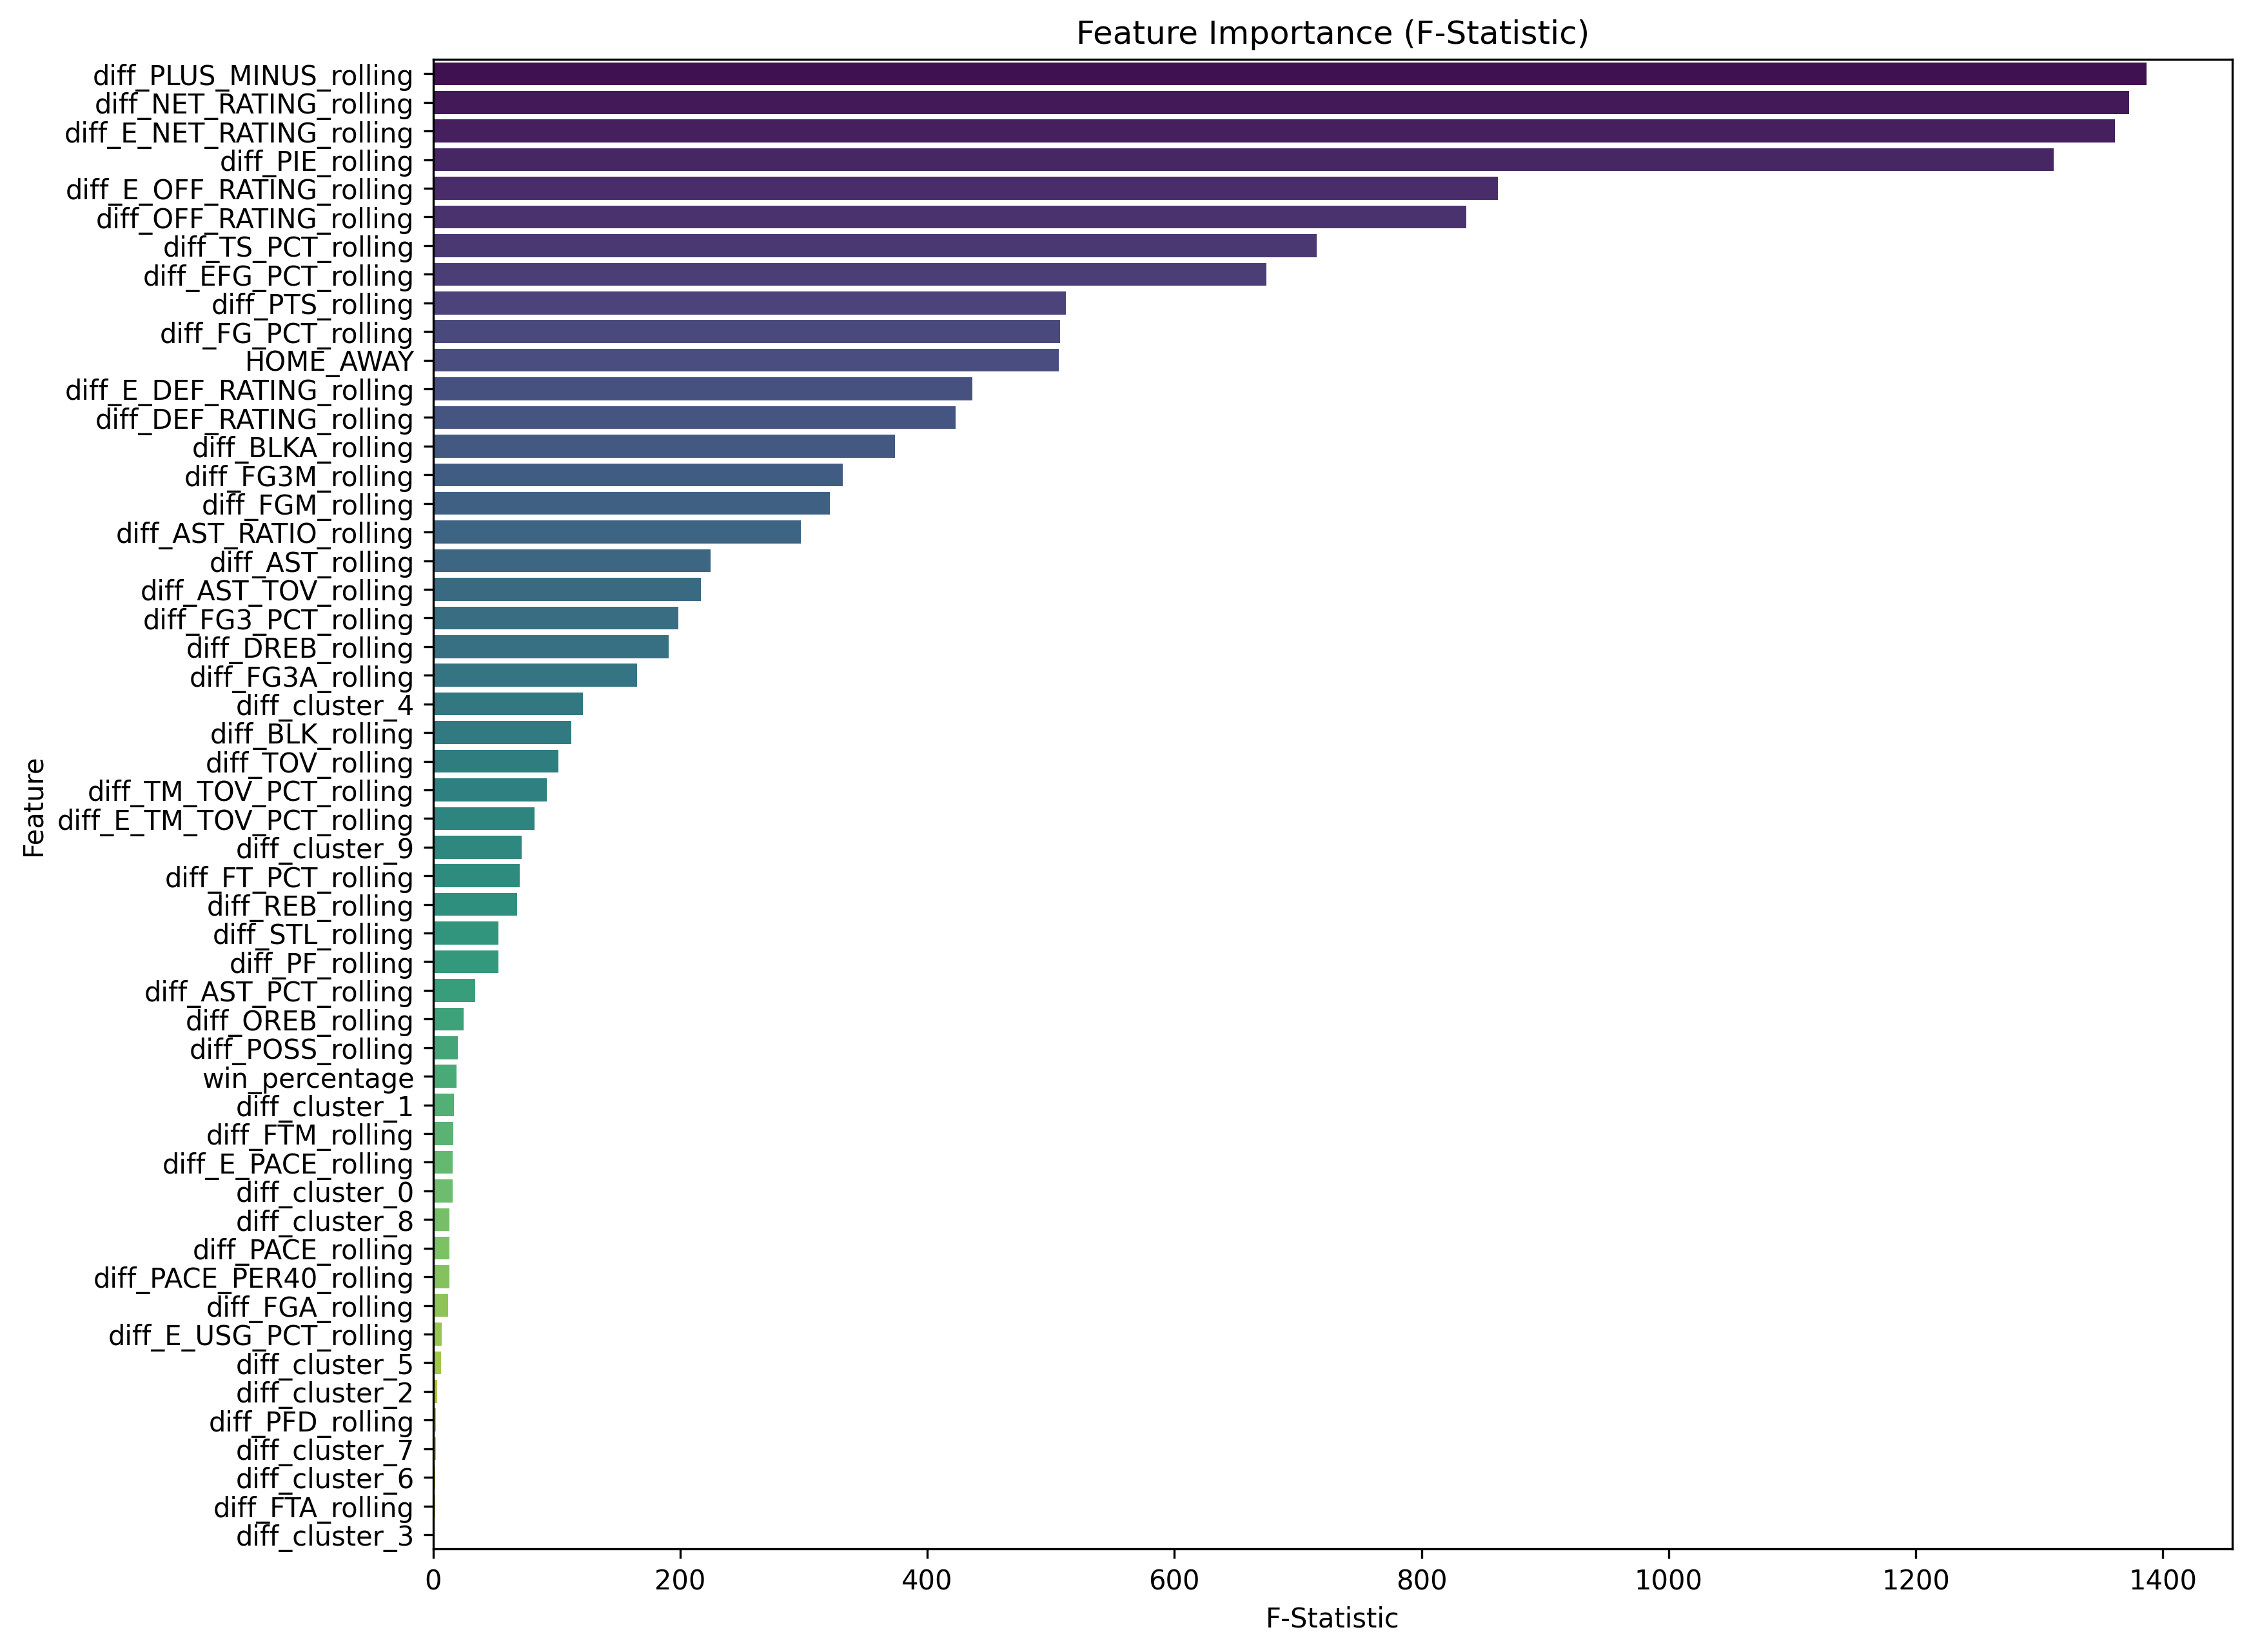

In [23]:
from sklearn.feature_selection import f_classif

y = df_model_cleaned[['WL']]
X = df_model_cleaned.drop('WL',axis=1).select_dtypes(include=['float64', 'int64']).drop(['TEAM_ID','GAME_ID'],axis = 1)
f_statistic, p_values = f_classif(X, y)

results_df = pd.DataFrame({
    'Feature': X.columns,
    'F-Statistic': f_statistic,
    'p-Value': p_values
})
results_df = results_df.sort_values(by='F-Statistic', ascending=False)


fig, ax = plt.subplots(1, 1, figsize=(12, 10), dpi=300)

sns.barplot(x='F-Statistic', y='Feature', data=results_df, palette='viridis', ax=ax)
ax.set_title('Feature Importance (F-Statistic)')

plt.show()

# Training and Scaling

In [137]:
null_counts = df_model_cleaned.isnull().sum()
print(null_counts[null_counts > 0])

Series([], dtype: int64)


In [138]:
# final two seasons for the test set
df_test = df_model_cleaned[df_model_cleaned['SEASON_YEAR'].isin(['2022-23', '2023-24'])]

# remaining seasons for training and validation
df_train_val = df_model_cleaned[~df_model_cleaned['SEASON_YEAR'].isin(['2022-23', '2023-24'])]

X_train_val = df_train_val.drop(columns=['SEASON_YEAR', 'WL'])
y_train_val = df_train_val['WL']

X_test = df_test.drop(columns=['SEASON_YEAR', 'WL'])
y_test = df_test['WL']

# 80/20 split for training and val
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (16932, 54)
Validation set shape: (4234, 54)
Test set shape: (4858, 54)


In [139]:
X_train_identifiers = X_train[['TEAM_ID', 'GAME_ID']]
X_val_identifiers = X_val[['TEAM_ID', 'GAME_ID']]
X_test_identifiers = X_test[['TEAM_ID', 'GAME_ID']]

X_train = X_train.drop(columns=['TEAM_ID', 'GAME_ID'])
X_val = X_val.drop(columns=['TEAM_ID', 'GAME_ID'])
X_test = X_test.drop(columns=['TEAM_ID', 'GAME_ID'])

In [140]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_val.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

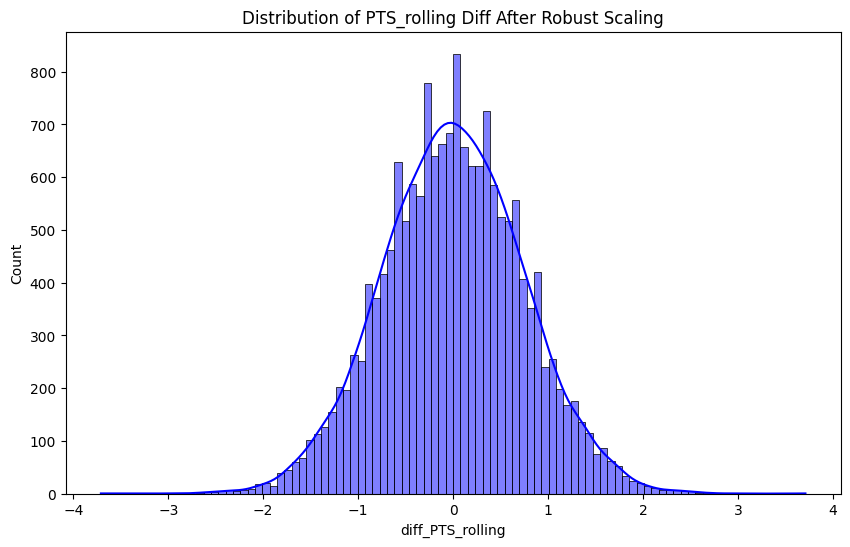

In [141]:
plt.figure(figsize=(10, 6))
sns.histplot(X_train_scaled_df['diff_PTS_rolling'], kde=True, color='blue')
plt.title('Distribution of PTS_rolling Diff After Robust Scaling')
plt.show()

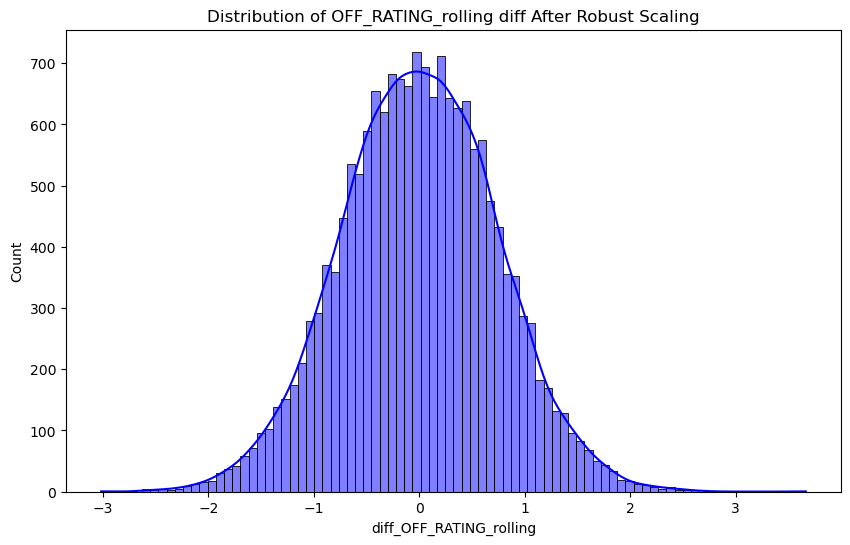

In [21]:
plt.figure(figsize=(10, 6))
sns.histplot(X_train_scaled_df['diff_OFF_RATING_rolling'], kde=True, color='blue')
plt.title('Distribution of OFF_RATING_rolling diff After Robust Scaling')
plt.show()

# Model

## Logistic Regression

In [142]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_val.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [143]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)

log_reg.fit(X_train_scaled_df, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [144]:
y_val_pred = log_reg.predict(X_val_scaled_df)

val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.4f}")

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

print("Classification Report:")
print(classification_report(y_val, y_val_pred))

Validation Accuracy: 0.6299
Confusion Matrix:
[[1318  799]
 [ 768 1349]]
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.62      0.63      2117
           1       0.63      0.64      0.63      2117

    accuracy                           0.63      4234
   macro avg       0.63      0.63      0.63      4234
weighted avg       0.63      0.63      0.63      4234



## XGBoost

In [147]:
import xgboost as xgb

# convert the dataset into DMatrix (optimized for XGBoost) -
dtrain = xgb.DMatrix(X_train_scaled_df, label=y_train)
dval = xgb.DMatrix(X_val_scaled_df, label=y_val)
dtest = xgb.DMatrix(X_test_scaled_df, label=y_test)
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.1,  # learning rate
    'max_depth': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

evals = [(dtrain, 'train'), (dval, 'eval')]
xgb_model = xgb.train(params, dtrain, num_boost_round=100, early_stopping_rounds=10, evals=evals)

y_val_pred = (xgb_model.predict(dval) > 0.5).astype(int)

print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print(confusion_matrix(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

[0]	train-logloss:0.68339	eval-logloss:0.68465
[1]	train-logloss:0.67546	eval-logloss:0.67842
[2]	train-logloss:0.66864	eval-logloss:0.67285
[3]	train-logloss:0.66265	eval-logloss:0.66804
[4]	train-logloss:0.65742	eval-logloss:0.66372
[5]	train-logloss:0.65285	eval-logloss:0.66002
[6]	train-logloss:0.64928	eval-logloss:0.65781
[7]	train-logloss:0.64556	eval-logloss:0.65561
[8]	train-logloss:0.64276	eval-logloss:0.65430
[9]	train-logloss:0.63986	eval-logloss:0.65252
[10]	train-logloss:0.63699	eval-logloss:0.65084
[11]	train-logloss:0.63437	eval-logloss:0.64943
[12]	train-logloss:0.63227	eval-logloss:0.64779
[13]	train-logloss:0.63008	eval-logloss:0.64688
[14]	train-logloss:0.62789	eval-logloss:0.64577
[15]	train-logloss:0.62595	eval-logloss:0.64521
[16]	train-logloss:0.62427	eval-logloss:0.64433
[17]	train-logloss:0.62248	eval-logloss:0.64378
[18]	train-logloss:0.62086	eval-logloss:0.64348
[19]	train-logloss:0.61936	eval-logloss:0.64310
[20]	train-logloss:0.61781	eval-logloss:0.64264
[2

In [135]:
param_grid = {
    'max_depth': [5],
    'learning_rate': [0.01],
    'n_estimators': [300],
    'subsample': [0.7],
    'colsample_bytree': [0.8]
}

xgb_clf = xgb.XGBClassifier()
grid_search = GridSearchCV(xgb_clf, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled_df, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Validation Accuracy:", grid_search.best_score_)

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.7}
Best Validation Accuracy: 0.6317623434916135


## Neural Net

In [159]:
#prep Data
#convert to tensors
X_train_tensor = torch.tensor(X_train_scaled_df.values, dtype=torch.float32)  
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)  
X_val_tensor = torch.tensor(X_val_scaled_df.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_scaled_df.values, dtype=torch.float32)  
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# combine into tensor dataset 
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoader instances
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)  # Shuffle for training, No shuffle for testing, tried turning off for stability 
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Epoch [2/20], Training Loss: 0.6886, Training Accuracy: 0.5399,Validation Loss: 0.6863, Validation Accuracy: 0.5694
Epoch [3/20], Training Loss: 0.6837, Training Accuracy: 0.5606,Validation Loss: 0.6795, Validation Accuracy: 0.5888
Epoch [4/20], Training Loss: 0.6782, Training Accuracy: 0.5904,Validation Loss: 0.6745, Validation Accuracy: 0.6150
Epoch [5/20], Training Loss: 0.6748, Training Accuracy: 0.6016,Validation Loss: 0.6720, Validation Accuracy: 0.6181
Epoch [6/20], Training Loss: 0.6726, Training Accuracy: 0.6098,Validation Loss: 0.6691, Validation Accuracy: 0.6242
Epoch [7/20], Training Loss: 0.6681, Training Accuracy: 0.6142,Validation Loss: 0.6659, Validation Accuracy: 0.6271
Epoch [8/20], Training Loss: 0.6648, Training Accuracy: 0.6182,Validation Loss: 0.6628, Validation Accuracy: 0.6280
Epoch [9/20], Training Loss: 0.6639, Training Accuracy: 0.6203,Validation Loss: 0.6610, Validation Accuracy: 0.6297
Epoch [10/20], Training Loss: 0.6608, Training Accuracy: 0.6250,Validati

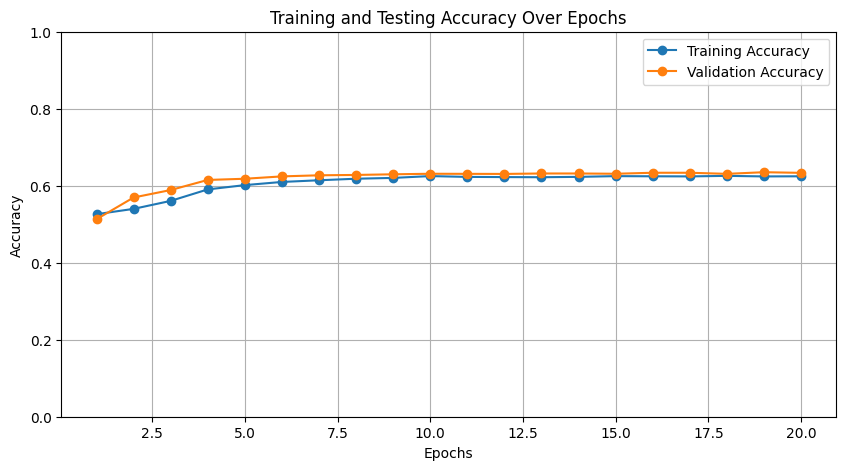

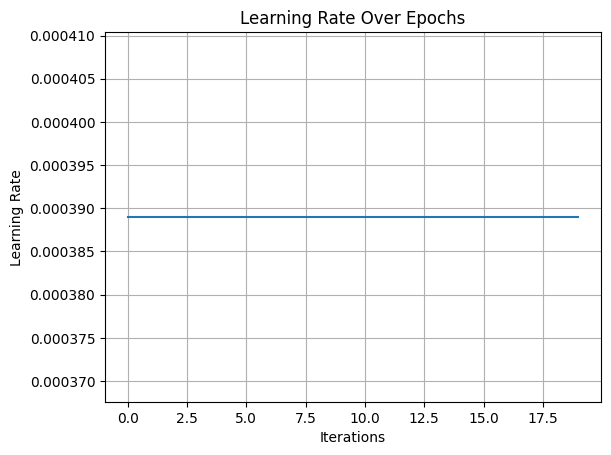

In [160]:
device = torch.device('cpu')
# Define the main neural network model
class WinLossNet(nn.Module):
    def __init__(self,layer_sizes, drop_rate = 0.4284):
        super(WinLossNet, self).__init__()

        # main Layers
        self.fc1 = nn.Linear(52, layer_sizes[0])
        self.fc2 = nn.Linear(layer_sizes[0], layer_sizes[1])
        self.dropout = nn.Dropout(p=drop_rate)
        self.fc3 = nn.Linear(layer_sizes[1], layer_sizes[2])
        self.fc4 = nn.Linear(layer_sizes[2], layer_sizes[3])
        self.fc5 = nn.Linear(layer_sizes[3], 1)
        self.leaky_relu = nn.LeakyReLU()

    def forward(self, x):
        # main
        x = self.leaky_relu(self.fc1(x))
        x = self.leaky_relu(self.fc2(x))
        x = self.leaky_relu(self.fc3(x))
        x = self.leaky_relu(self.fc4(x))
        x = self.dropout(x)
        x = self.fc5(x)
        return x

# Instantiate the model, feed weights here to work with search function
model = WinLossNet([256, 128, 32, 16])

#send to device
model = model.to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()   # Combines Sigmoid + BCELoss, feeds data through sigmoid function
optimizer = optim.Adam(model.parameters(), lr=0.000389,weight_decay=0.008631 )#1e-5)

########even more kaden fun, let


train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []
learning_rates = []
# knobs
epochs = 20
#scheduler = StepLR(optimizer, step_size=17, gamma=.95)  # Change learning rate over time, different options to test
scheduler = ReduceLROnPlateau(optimizer,patience=3,factor=0.525,cooldown=0)

for epoch in range(epochs):
    model.train()        # Training time
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for i, (inputs, labels) in enumerate(train_loader, 0):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)   #issue ******
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total_preds += labels.size(0)
        correct_preds += (predicted == labels).sum().item()

    # Calculte the trainging epocs stats
    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_acc = correct_preds / total_preds
    train_loss_history.append(epoch_train_loss)
    train_acc_history.append(epoch_train_acc)


    # Validation phase
    model.eval()
    val_loss = 0.0
    correct_val_preds = 0
    total_val_preds = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move to device
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total_val_preds += labels.size(0)
            correct_val_preds += (predicted == labels).sum().item()

    #calculate validation stats
    epoch_val_loss = val_loss / len(val_loader)
    epoch_val_acc = correct_val_preds / total_val_preds
    val_loss_history.append(epoch_val_loss)
    val_acc_history.append(epoch_val_acc)

    if epoch > 0:
        print(f'Epoch [{epoch + 1}/{epochs}], '
              f'Training Loss: {epoch_train_loss:.4f}, Training Accuracy: {epoch_train_acc:.4f},'
              f'Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_acc:.4f}')

    # Step the scheduler
    scheduler.step(epoch_val_loss)
    #save chnages in learning rate
    for param_group in optimizer.param_groups:
        learning_rates.append(param_group['lr'])

# Plot plot plot
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, epochs + 1), train_acc_history, label='Training Accuracy', marker='o')
plt.plot(np.arange(1, epochs + 1), val_acc_history, label='Validation Accuracy', marker='o')
plt.title('Training and Testing Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()


plt.plot(learning_rates)
plt.title('Learning Rate Over Epochs')
plt.xlabel('Iterations')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.show()

In [108]:
torch.save(model.state_dict(), 'model.pth')

best_model = model
#to load model
#model.load_state_dict(torch.load('model.pth'))

In [30]:
# Define the objective function for hyperparameter search, close to hand tuning design above
def objective(params):
    batch_size = params['batch_size']
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = WinLossNet(layer_sizes=params['layer_sizes'],drop_rate=params['drop_rate']).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=params['lr'],weight_decay=params['weight_decay'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=params['patience'], factor= params['factor'])

    # Training loop
    model.train()
    for epoch in range(params['epochs']):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Validation loop
    model.eval()
    correct, total,val_loss = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)
    scheduler.step(avg_val_loss)

    accuracy = correct / total
    return {'loss': -accuracy, 'status': STATUS_OK}

# Define the search space
space = {
    'layer_sizes': hp.choice('layer_sizes', [
        [256, 174, 96, 48],
        [256, 128, 96, 32],
        [256, 128, 64, 32],
        [324, 256, 145, 64],
        [512, 256, 128, 64],

    ]),
    'drop_rate': hp.uniform('drop_rate', 0.01, 0.7),
    'lr': hp.loguniform('lr', -5, -1),
    'epochs': hp.choice('epochs', [10,15, 20, 25,30]),
    'patience': hp.choice('patience', [2,3,5,6,7,8,9]),
    'factor' : hp.uniform('factor', 0.1,0.7),
    'weight_decay' : hp.loguniform('weight_decay',-5,-1),
    'batch_size' : hp.choice('batch_size', [16,32,64,128])
}


# Begin the hunt
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=400, trials=trials)

print(best)


100%|███████| 400/400 [29:43<00:00,  4.46s/trial, best loss: -0.639348134152102]
{'batch_size': 3, 'drop_rate': 0.5333954280617453, 'epochs': 3, 'factor': 0.13965030530049044, 'layer_sizes': 1, 'lr': 0.01289818002531513, 'patience': 4, 'weight_decay': 0.008185389494909802}


In [153]:
 best_model.eval()

true_values = []
predicted_values = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = torch.sigmoid(model(inputs))
        true_values.append(labels.cpu().numpy())
        predicted_values.append(outputs.cpu().numpy())

true_values = np.concatenate(true_values)
predicted_values = np.concatenate(predicted_values)

results_df = pd.DataFrame({'True_Values':true_values.flatten(),
'pred_Values' : predicted_values.flatten()})
results_df['pred_Values_B'] = (results_df['pred_Values'] > 0.5).astype(int)
results_df = results_df.merge(X_val_identifiers.reset_index().drop('index',axis = 1), left_index=True, right_index=True)
results_df = results_df.merge(X_val.reset_index().drop('index',axis = 1),left_index=True, right_index=True)


In [110]:
results_df['correct_prediction'] = (results_df['True_Values'] == results_df['pred_Values_B']).astype(int)
results_df

,True_Values,pred_Values,pred_Values_B,TEAM_ID,GAME_ID,HOME_AWAY,win_percentage,diff_FGM_rolling,diff_FGA_rolling,diff_FG_PCT_rolling,...,diff_cluster_1,diff_cluster_2,diff_cluster_3,diff_cluster_4,diff_cluster_5,diff_cluster_6,diff_cluster_7,diff_cluster_8,diff_cluster_9,correct_prediction
0,0.0,0.642992,1,1610612737,21300827,1,0.454545,-4.50,-9.25,-0.00375,...,-0.098500,0.614367,0.213367,-0.411833,-0.268000,0.000000,-0.058667,0.000000,0.000000,0
1,1.0,0.642058,1,1610612757,21600208,0,0.533333,-0.50,3.25,-0.01925,...,0.177161,0.245268,0.021000,0.051696,0.000000,0.226554,0.000000,0.073679,-0.151268,1
2,1.0,0.629137,1,1610612759,21800262,1,0.500000,1.25,10.50,-0.03950,...,-0.216429,-0.020429,0.031286,0.344429,0.060143,0.000000,0.367000,0.010714,0.000000,1
3,0.0,0.547882,1,1610612765,21900386,0,0.400000,-4.75,1.50,-0.06275,...,0.330333,0.044167,0.713000,-0.084000,-0.127833,0.000000,0.000000,-0.445333,0.116000,0
4,0.0,0.434432,0,1610612743,21900150,1,0.777778,-2.75,-2.00,-0.02225,...,0.332292,-0.105000,-0.227000,0.225000,0.009958,0.000000,0.000000,0.048667,0.211125,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4229,0.0,0.502815,1,1610612754,21800886,0,0.661017,-3.00,-5.25,-0.00225,...,-0.066446,0.136125,0.027875,-0.066500,0.000000,0.112250,-0.038714,-0.135054,0.000000,0
4230,1.0,0.341834,0,1610612753,22101108,1,0.270270,-3.00,1.50,-0.04300,...,0.151286,0.157286,-0.187286,0.193714,-0.186286,0.025286,0.000000,0.005714,0.000000,0
4231,0.0,0.458428,0,1610612766,21300996,1,0.492537,3.25,2.25,0.03050,...,-0.169667,-0.100375,-0.157542,0.100375,0.153500,-0.088000,-0.138708,0.050000,0.013875,1
4232,1.0,0.566140,1,1610612761,21900473,0,0.677419,-7.50,-3.75,-0.06225,...,0.153571,0.000000,0.004429,-0.084000,-0.009000,0.000000,0.000000,-0.024429,-0.012714,1


In [111]:
final_results = results_df

In [112]:
max(final_results['GAME_ID'].astype(str).str[-4:])

'1312'

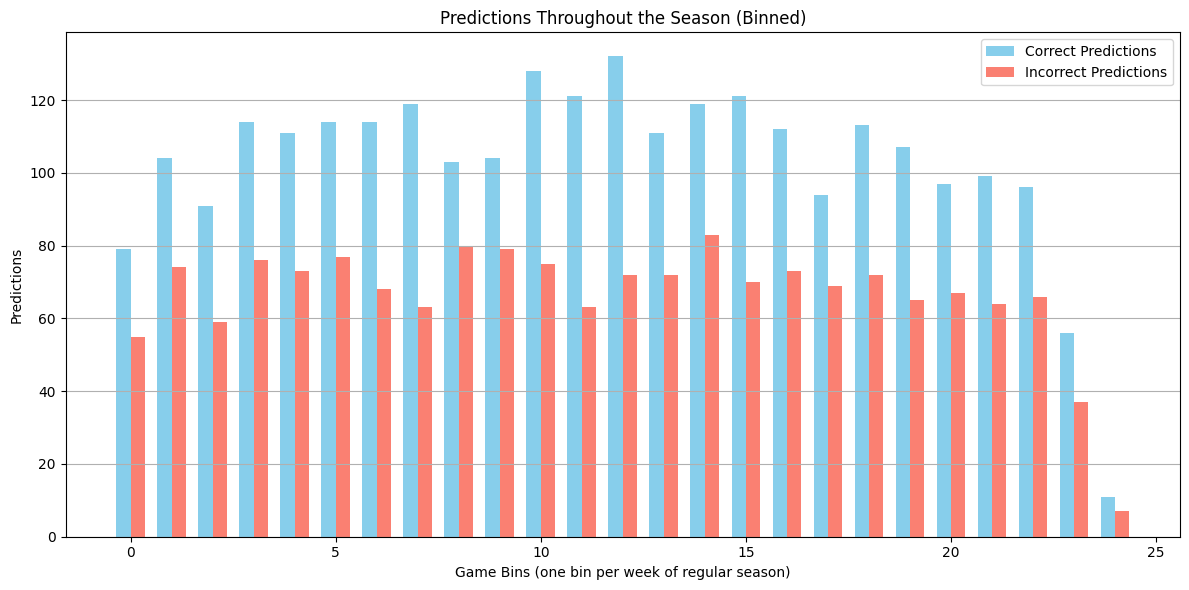

In [156]:
final_results = results_df.copy()
final_results['season'] = final_results['GAME_ID'].astype(str).str[:3]  # First three digits for the season
final_results['game_number'] = final_results['GAME_ID'].astype(str).str[-4:]  # Last three digits for the game number


final_results['correct_prediction'] = (final_results['True_Values'] == final_results['pred_Values_B']).astype(int)
final_results['incorrect_prediction'] = (final_results['True_Values'] != final_results['pred_Values_B']).astype(int)

num_bins = 25
bins = np.linspace(1, 1303, num_bins + 1) # 1303 = max number of games in a seasons
final_results['game_number'] = final_results['game_number'].astype(int)
final_results['binned_game_number'] = pd.cut(final_results['game_number'], bins=bins, include_lowest=True)

binned_summary = final_results.groupby('binned_game_number').agg(
    correct_predictions=('correct_prediction', 'sum'),
    incorrect_predictions=('incorrect_prediction', 'sum')
).reset_index()

# make pretty plot

plt.figure(figsize=(12, 6))
bar_width = 0.35
x = np.arange(len(binned_summary))

plt.bar(x - bar_width/2, binned_summary['correct_predictions'], width=bar_width, label='Correct Predictions', color='skyblue')
plt.bar(x + bar_width/2, binned_summary['incorrect_predictions'], width=bar_width, label='Incorrect Predictions', color='salmon')

plt.title('Predictions Throughout the Season (Binned)')
plt.xlabel('Game Bins (one bin per week of regular season)')
plt.ylabel('Predictions')

plt.legend()
plt.tight_layout()
plt.grid(axis='y')
plt.savefig('charts/through_season.png')
plt.show()


## Playing with SHAP

In [36]:
# JS visualization for Jupyter
shap.initjs()

explainer = shap.Explainer(xgb_model)
shap_values = explainer.shap_values(X_val_scaled_df)

shap.force_plot(explainer.expected_value, shap_values[0,:], X_val_scaled_df.iloc[0,:])

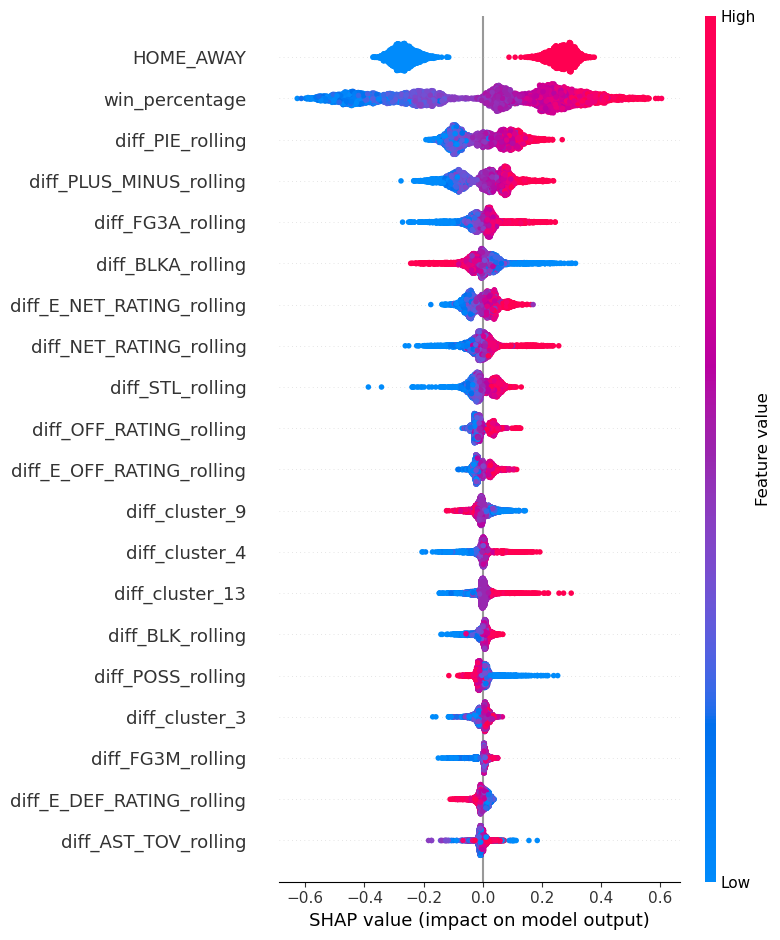

In [37]:
shap.summary_plot(shap_values, X_val_scaled_df)

## Test: Model Blending

In [114]:
log_reg_pred_proba = log_reg.predict_proba(X_val_scaled_df)[:, 1]

xgb_val_pred_proba = xgb_model.predict(dval) 

model.eval()
nn_pred_proba = []
with torch.no_grad():
    for inputs, _ in val_loader: 
        inputs = inputs.to(device)
        outputs = torch.sigmoid(model(inputs))
        nn_pred_proba.extend(outputs.cpu().numpy()) 
nn_pred_proba = np.array(nn_pred_proba).flatten()

blended_proba = (log_reg_pred_proba + xgb_val_pred_proba + nn_pred_proba) / 3

blended_pred = (blended_proba >= 0.5).astype(int)

blended_accuracy = accuracy_score(y_val, blended_pred)
print(f"Blended Validation Accuracy: {blended_accuracy:.4f}")

print("Blended Confusion Matrix:")
print(confusion_matrix(y_val, blended_pred))

print("Blended Classification Report:")
print(classification_report(y_val, blended_pred))

Blended Validation Accuracy: 0.6353
Blended Confusion Matrix:
[[1289  828]
 [ 716 1401]]
Blended Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.61      0.63      2117
           1       0.63      0.66      0.64      2117

    accuracy                           0.64      4234
   macro avg       0.64      0.64      0.64      4234
weighted avg       0.64      0.64      0.64      4234



## AUC for models

In [158]:
log_reg_pred_proba = log_reg.predict_proba(X_test_scaled_df)[:, 1]  
log_reg_auc = roc_auc_score(y_test, log_reg_pred_proba)
print(f"Logistic Regression AUC: {log_reg_auc:.4f}")

xgb_val_pred_proba = xgb_model.predict(dtest)  
xgb_auc = roc_auc_score(y_test, xgb_val_pred_proba)
print(f"XGBoost AUC: {xgb_auc:.4f}")

nn_pred_proba = []
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = torch.sigmoid(model(inputs))
        nn_pred_proba.extend(outputs.cpu().numpy())
nn_pred_proba = np.array(nn_pred_proba).flatten()
nn_auc = roc_auc_score(y_test, nn_pred_proba)
print(f"Neural Network AUC: {nn_auc:.4f}")

blended_proba = (log_reg_pred_proba + xgb_val_pred_proba + nn_pred_proba) / 3  # avg prob
blended_auc = roc_auc_score(y_test, blended_proba)
print(f"Blended Model AUC: {blended_auc:.4f}")

Logistic Regression AUC: 0.6529
XGBoost AUC: 0.6600


ValueError: Found input variables with inconsistent numbers of samples: [4858, 7284]

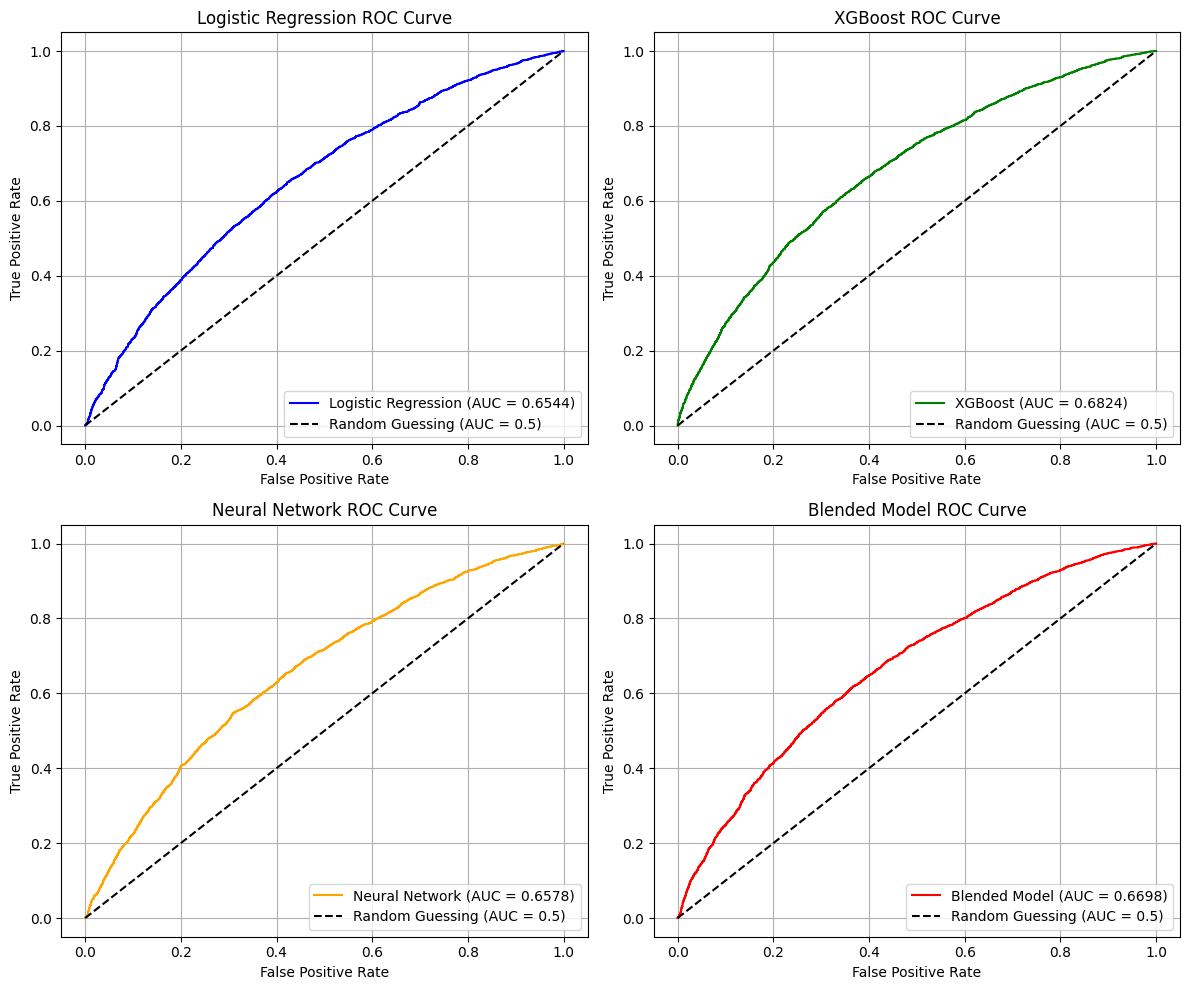

In [120]:
log_reg_fpr, log_reg_tpr, _ = roc_curve(y_test, log_reg_pred_proba)
log_reg_auc = auc(log_reg_fpr, log_reg_tpr)

xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_val_pred_proba)
xgb_auc = auc(xgb_fpr, xgb_tpr)

nn_fpr, nn_tpr, _ = roc_curve(y_test, nn_pred_proba)
nn_auc = auc(nn_fpr, nn_tpr)

blended_fpr, blended_tpr, _ = roc_curve(y_test, blended_proba)
blended_auc = auc(blended_fpr, blended_tpr)

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

axs[0, 0].plot(log_reg_fpr, log_reg_tpr, color='blue', label=f'Logistic Regression (AUC = {log_reg_auc:.4f})')
axs[0, 0].plot([0, 1], [0, 1], 'k--', label='Random Guessing (AUC = 0.5)')
axs[0, 0].set_title('Logistic Regression ROC Curve')
axs[0, 0].set_xlabel('False Positive Rate')
axs[0, 0].set_ylabel('True Positive Rate')
axs[0, 0].legend(loc='lower right')
axs[0, 0].grid(True)

axs[0, 1].plot(xgb_fpr, xgb_tpr, color='green', label=f'XGBoost (AUC = {xgb_auc:.4f})')
axs[0, 1].plot([0, 1], [0, 1], 'k--', label='Random Guessing (AUC = 0.5)')
axs[0, 1].set_title('XGBoost ROC Curve')
axs[0, 1].set_xlabel('False Positive Rate')
axs[0, 1].set_ylabel('True Positive Rate')
axs[0, 1].legend(loc='lower right')
axs[0, 1].grid(True)

axs[1, 0].plot(nn_fpr, nn_tpr, color='orange', label=f'Neural Network (AUC = {nn_auc:.4f})')
axs[1, 0].plot([0, 1], [0, 1], 'k--', label='Random Guessing (AUC = 0.5)')
axs[1, 0].set_title('Neural Network ROC Curve')
axs[1, 0].set_xlabel('False Positive Rate')
axs[1, 0].set_ylabel('True Positive Rate')
axs[1, 0].legend(loc='lower right')
axs[1, 0].grid(True)

axs[1, 1].plot(blended_fpr, blended_tpr, color='red', label=f'Blended Model (AUC = {blended_auc:.4f})')
axs[1, 1].plot([0, 1], [0, 1], 'k--', label='Random Guessing (AUC = 0.5)')
axs[1, 1].set_title('Blended Model ROC Curve')
axs[1, 1].set_xlabel('False Positive Rate')
axs[1, 1].set_ylabel('True Positive Rate')
axs[1, 1].legend(loc='lower right')
axs[1, 1].grid(True)

plt.tight_layout()
plt.savefig('charts/roc_curves_individual.png')
plt.show()

In [157]:
log_reg_fpr, log_reg_tpr, _ = roc_curve(y_val, log_reg_pred_proba)
log_reg_auc = auc(log_reg_fpr, log_reg_tpr)

xgb_fpr, xgb_tpr, _ = roc_curve(y_val, xgb_val_pred_proba)
xgb_auc = auc(xgb_fpr, xgb_tpr)

nn_fpr, nn_tpr, _ = roc_curve(y_val, nn_pred_proba)
nn_auc = auc(nn_fpr, nn_tpr)

blended_fpr, blended_tpr, _ = roc_curve(y_val, blended_proba)
blended_auc = auc(blended_fpr, blended_tpr)

plt.figure(figsize=(10, 8))
plt.plot(log_reg_fpr, log_reg_tpr, label=f'Logistic Regression (AUC = {log_reg_auc:.4f})', color='blue')
plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost (AUC = {xgb_auc:.4f})', color='green')
plt.plot(nn_fpr, nn_tpr, label=f'Neural Network (AUC = {nn_auc:.4f})', color='orange')
plt.plot(blended_fpr, blended_tpr, label=f'Blended Model (AUC = {blended_auc:.4f})', color='red')

# 50% random guessing line
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing (AUC = 0.5)')

plt.title('ROC Curves for Models')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [4234, 4858]